# <a id='toc1_'></a>[Assignment 2](#toc0_)
### <a id='toc1_1_1_'></a>[Student ID: 460374219](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Assignment 2](#toc1_)    
    - [Student ID: 460374219](#toc1_1_1_)    
  - [Import Libraries](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Import Libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [3]:
def load_data():
    data = pd.read_csv('weatherAUS_clean.csv')
    return data

data = load_data()
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,14,44.0,13,14,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0,0
1,2008-12-02,Albury,7.4,25.1,0.0,15,44.0,6,15,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,0
2,2008-12-03,Albury,12.9,25.7,0.0,16,46.0,13,15,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,0
3,2008-12-04,Albury,9.2,28.0,0.0,5,24.0,9,0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,0
4,2008-12-05,Albury,17.5,32.3,1.0,14,41.0,1,7,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,0


In [38]:
# Nans
data.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
WindGustDir          0
WindGustSpeed     5925
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am      11597
Pressure3pm      11597
Temp9am              0
Temp3pm              0
RainToday            0
RainTomorrow         0
dtype: int64

## Feature Selection

In [57]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# Numerical features
X = data[["Humidity9am", "Humidity3pm", "Rainfall", "RainToday"]]
y = data["RainTomorrow"]

sc = StandardScaler()
pca = decomposition.PCA()

X = sc.fit_transform(X)
X = pca.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Model Selection

In [60]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

## Model Evaluation

In [61]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report
import pandas as pd
key='0=No Rain, 1=Rain'
print('Classification report ({}):\n'.format(key))
print(classification_report(y_test, classifier.predict(X_test)))

y_actu = pd.Series(y_test, name='Actual')
y_pred_s1 = pd.Series(classifier.predict(X_test), name='Predicted')
confusion_matrix = pd.crosstab(y_actu, y_pred_s1)
print(confusion_matrix)
print()

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Classification report (0=No Rain, 1=Rain):

              precision    recall  f1-score   support

           0       0.84      0.96      0.90     21813
           1       0.72      0.39      0.51      6345

    accuracy                           0.83     28158
   macro avg       0.78      0.68      0.70     28158
weighted avg       0.82      0.83      0.81     28158

Predicted     0    1
Actual              
0          3830  550
1          1105  150

Accuracy: 83.29 %
Standard Deviation: 0.17 %


Confusion matrix (0=No Rain, 1=Rain):



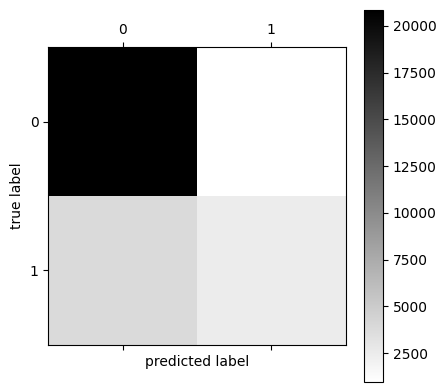

In [63]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print('Confusion matrix ({}):\n'.format(key))
plt.matshow(confusion_matrix(y_test, classifier.predict(X_test)), cmap=plt.cm.binary, interpolation='nearest')
plt.colorbar()
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()

## Hyperparameter Tuning

Tuning the C and penalty hyperparameters of the logistic regression model using GridSearchCV.

In [29]:
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression()

# using pipeline to chain the steps together
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[("sc", sc), ("pca", pca), ("logistic_Reg", log_reg)])

# Number of components to keep
n_components = list(range(1, X.shape[1] + 1, 1))
print(n_components)

# Tuning the hyper-parameters
C = np.logspace(-4, 4, 50)
penalty = ["l1", "l2"]

parameters = dict(
    pca__n_components=n_components, logistic_Reg__C=C, logistic_Reg__penalty=penalty
)

# Grid search
clf = GridSearchCV(pipe, parameters, n_jobs=-1)
clf.fit(X_train, y_train)

# Best hyper-parameters
print("Best Hyper-Parameters: ", clf.best_params_)
print("Best Score: ", clf.best_score_)


[1, 2, 3, 4]


/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1000 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/rush/uni/COMP5310/assignment2/venv/lib/python3.10/site-packages/

Best Hyper-Parameters:  {'logistic_Reg__C': 0.12648552168552957, 'logistic_Reg__penalty': 'l2', 'pca__n_components': 4}
Best Score:  0.8328760942466976
